In [49]:
import jsonlines
import numpy as np
from matplotlib import pyplot as plt

def process_token_probs(jsonl_file):
    mean_matrix = None
    var_matrix = None
    count_matrix = None

    with jsonlines.open(jsonl_file) as reader:
        for line in reader:

            matrix = np.zeros((1, 512))
            token_probs = line.get("token_probs", [])
            non_zero_token_probs = [tp for tp in token_probs if tp != 0]

            if len(non_zero_token_probs) < 512:
                matrix[0, :len(non_zero_token_probs)] = np.array(non_zero_token_probs)
            else:
                matrix[0] = np.array(non_zero_token_probs[:512])

            if mean_matrix is None:
                mean_matrix = matrix
                var_matrix = matrix**2
                count_matrix = (matrix != 0).astype(int)  
            else:
                mean_matrix += matrix
                var_matrix += matrix**2
                count_matrix += (matrix != 0).astype(int)

    non_zero_count = count_matrix  
    non_zero_count[non_zero_count == 0] = 1
    mean_matrix /= non_zero_count
    var_matrix /= non_zero_count
    var_matrix -= mean_matrix**2

    return mean_matrix, var_matrix


benchmark_all=["gsm8k","MultiArith","gpqa","FOLIO","ContextHub_abductive","ContextHub_deductive","arc_challenge","arc_easy","MuSR","lsat","commensenseqa","piqa","siqa","sst-2"]
cot_gain=[41.21,63.34,7.81,-1.58,2.2,-3.12,2.82,2.31,-1.45,-1.58,1.81,-1.57,-0.92,-0.92]        #"Mistral-7B-Instruct-v0.3"
SC=[0.1193,0.08365,0.02984,0.1925,-0.141,-0.035,-0.1479,-0.1218,0.3173,0.1771,-0.04884,-0.069,0.1708,0.2051]         #"Mistral-7B-Instruct-v0.3"
SC2=[0.4285,0.2781,-0.4995,-0.0889,-0.454,-0.509,-0.694,-0.664,-0.452,-0.5528,-0.4241,-0.669,-0.773,-0.3955]

model= "Mistral-7B-Instruct-v0.3"    #"Phi-3.5-mini-instruct""Llama-3.1-8B-Instruct"  "Mistral-7B-Instruct-v0.3" 
benchmark=benchmark_all[1]   
jsonl_file = '../outputs/'+benchmark+'/mistralai/standard/'+ model +'.jsonl'      #mistralai
mean_matrix, var_matrix = process_token_probs(jsonl_file)


print("Mean matrix shape:", mean_matrix.shape)
print("Variance matrix shape:", var_matrix.shape)

subset_matrix = mean_matrix[:10, :5]
rounded_matrix = np.round(subset_matrix, 3)
print(rounded_matrix)



Mean matrix shape: (1, 512)
Variance matrix shape: (1, 512)
[[0.6   0.9   0.856 0.944 0.98 ]]


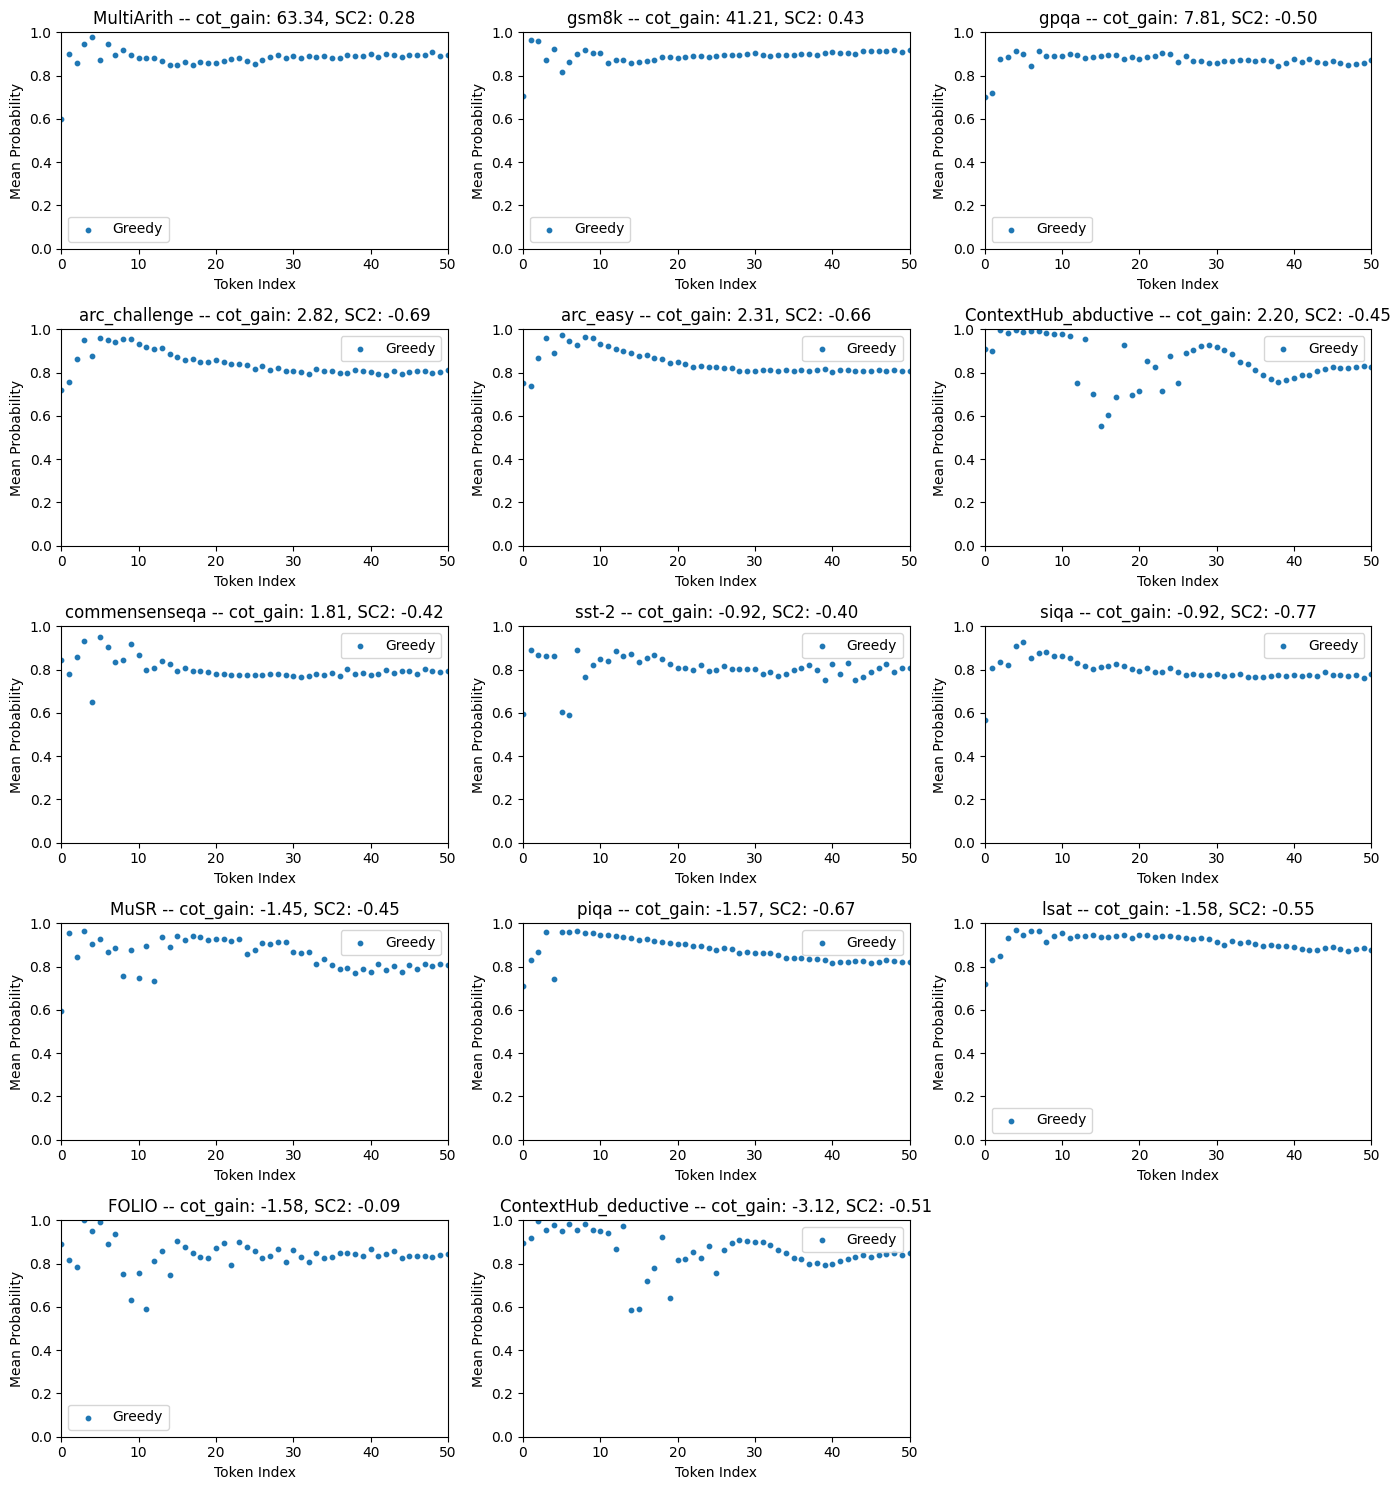

In [50]:
# Sort indices by cot_gain in descending order
sorted_indices = np.argsort(cot_gain)[::-1]

# Reorder the arrays based on sorted indices
sorted_benchmarks = np.array(benchmark_all)[sorted_indices]
sorted_cot_gain = np.array(cot_gain)[sorted_indices]
sorted_SC2 = np.array(SC2)[sorted_indices]

# Specify the benchmark for processing the jsonl file
benchmark = sorted_benchmarks[0]  # For example, process the highest cot_gain benchmark
# jsonl_file = f'outputs/{benchmark}/llama/standard/'+model+'.jsonl'
mean_matrix, var_matrix = process_token_probs(jsonl_file)

# model = "Mistral-7B-Instruct-v0.3"  # Specify the model

# Determine number of rows and columns for the subplots
rows = (len(benchmark_all) + 2) // 3  # Adjust this for more/less subplots
cols = 3

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Loop through each benchmark and plot on the corresponding subplot
for idx, benchmark in enumerate(sorted_benchmarks):
    jsonl_file = f'../outputs/{benchmark}/mistralai/standard/{model}.jsonl'  # Update with model-specific path
    
    mean_matrix, var_matrix = process_token_probs(jsonl_file)
    ax = axes[idx]

    # Plot mean probabilities for each benchmark
    ax.scatter(range(512), mean_matrix[0], label=f"Greedy", s=10)
    
    # Title with cot_gain and spearman_correlation
    ax.set_title(f"{benchmark} -- cot_gain: {sorted_cot_gain[idx]:.2f}, SC2: {sorted_SC2[idx]:.2f}", fontsize=12)
    ax.set_xlabel("Token Index", fontsize=10)
    ax.set_ylabel("Mean Probability", fontsize=10)
    ax.set_xlim(0, 50)  # Adjust the limits as necessary
    ax.set_ylim(0, 1)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Add legend
    ax.legend(fontsize=10)

# Hide any unused axes if there are more subplots than benchmarks
for i in range(len(sorted_benchmarks), len(axes)):
    axes[i].axis('off')

plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()

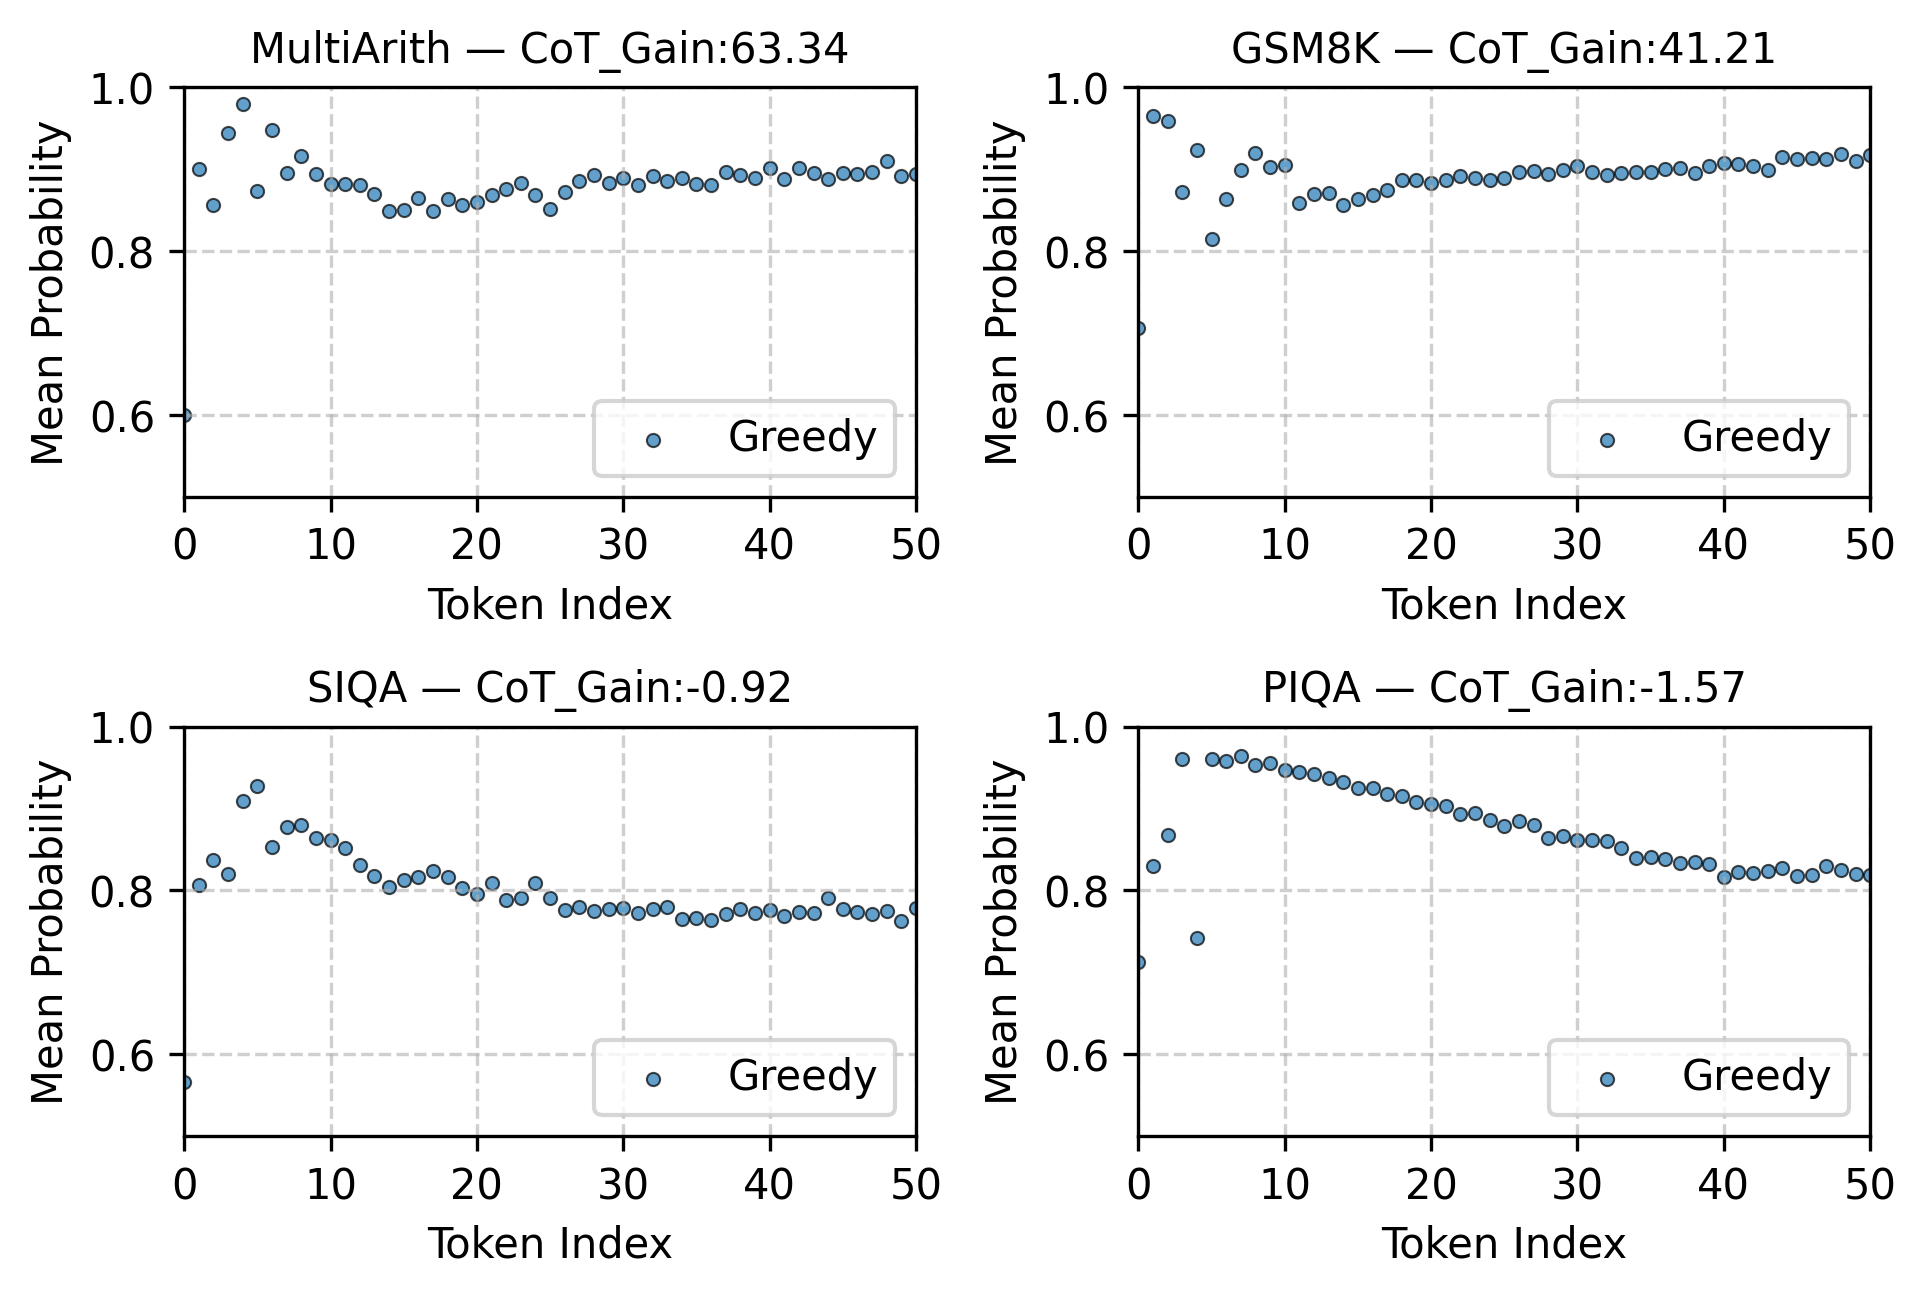

In [51]:
selected_benchmarks = ['MultiArith','gsm8k', 'siqa', 'piqa']
selected_benchmarks_new_name = ['MultiArith','GSM8K', 'SIQA', 'PIQA']
# filtered_benchmarks = sorted_benchmarks[np.isin(sorted_benchmarks, selected_benchmarks)]
selected_cot_gain = [63.34,41.21,-0.92,-1.57]

rows = (len(selected_benchmarks) + 1) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(6.5, 2.2 * rows), dpi=300)  # ICML paper-friendly sizing
axes = axes.flatten()

for idx, benchmark in enumerate(selected_benchmarks):
    jsonl_file = f'../outputs/{benchmark}/mistralai/standard/{model}.jsonl'  
    
    mean_matrix, var_matrix = process_token_probs(jsonl_file)
    ax = axes[idx]
    ax.scatter(range(512), mean_matrix[0], label="Greedy", s=10, alpha=0.7, edgecolors="k", linewidth=0.5)
    
    ax.set_title(f"{selected_benchmarks_new_name[idx]} — CoT_Gain:{selected_cot_gain[idx]:.2f}", fontsize=10)
    ax.set_xlabel("Token Index", fontsize=10)
    ax.set_ylabel("Mean Probability", fontsize=10)
    
    ax.set_xlim(0, 50)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)  # Subtle grid lines
    ax.set_ylim(0.5, 1)
    ax.legend(fontsize=10, loc="lower right")

# Turn off empty subplots
for i in range(len(selected_benchmarks), len(axes)):
    axes[i].axis('off')

plt.tight_layout(pad=1.0)  
plt.savefig("token-level analysis.pdf", bbox_inches="tight")  # Save in high quality for paper
plt.show()

/tmp/ipykernel_3210587/3329297171.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10, loc="lower right")


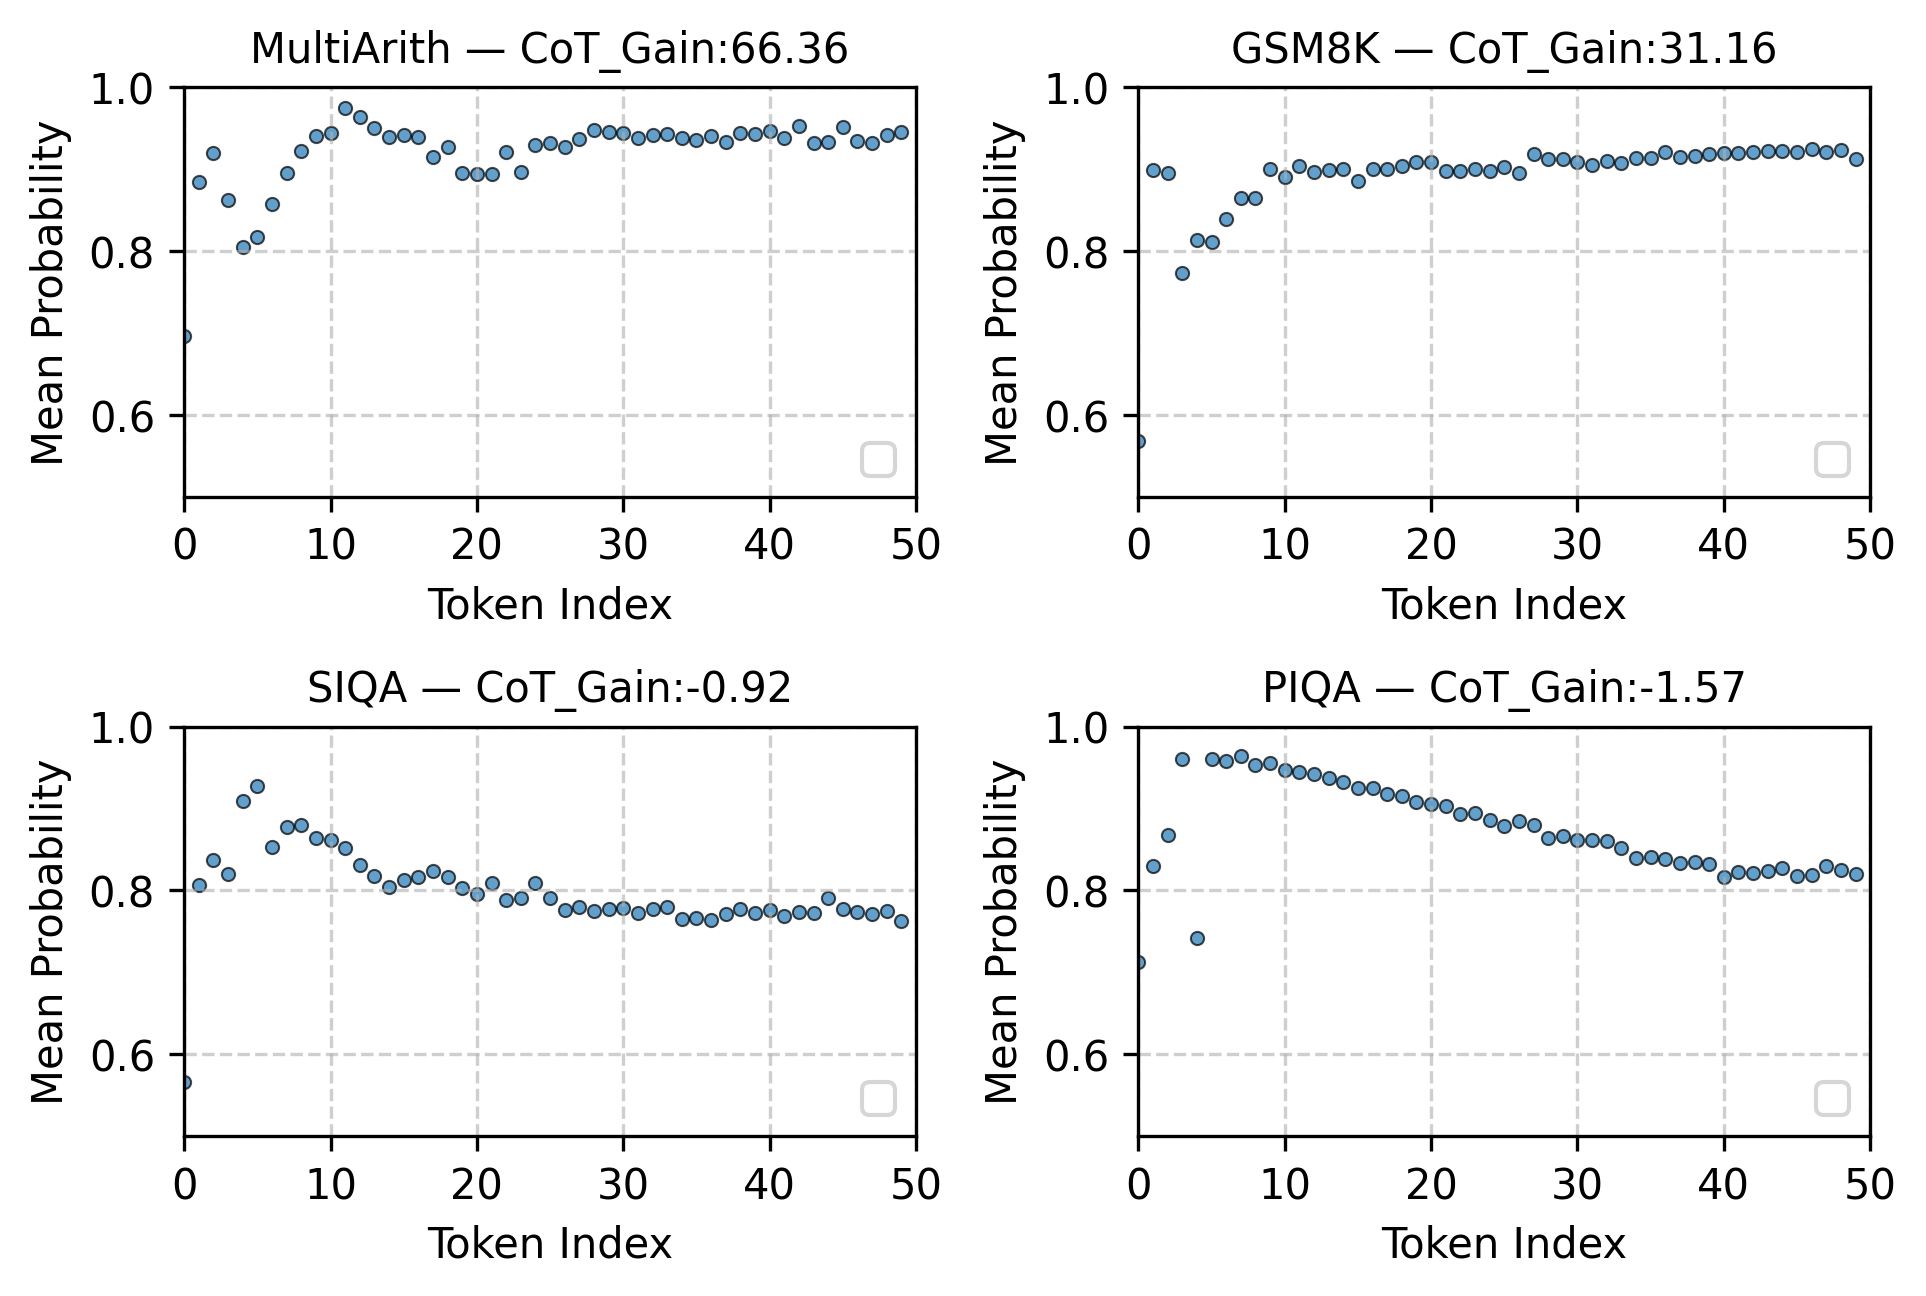

In [52]:
selected_benchmarks = ['MultiArith','gsm8k', 'siqa', 'piqa']
selected_benchmarks_new_name = ['MultiArith','GSM8K', 'SIQA', 'PIQA']
# filtered_benchmarks = sorted_benchmarks[np.isin(sorted_benchmarks, selected_benchmarks)]
selected_cot_gain = [66.36,31.16,-0.92,-1.57]

rows = (len(selected_benchmarks) + 1) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(6.5, 2.2 * rows), dpi=300)  #
axes = axes.flatten()

for idx, benchmark in enumerate(selected_benchmarks):
    if benchmark == 'siqa' or benchmark == 'piqa':
        jsonl_file = f'../outputs/{benchmark}/mistralai/standard/{model}.jsonl'  
        mean_matrix, var_matrix = process_token_probs(jsonl_file)
        # mean_matrix[0]=mean_matrix[0][:50]
        matrix=mean_matrix[0][:50]
    elif benchmark == 'gsm8k':
        matrix = [
    0.56834358, 0.89952453, 0.89551883, 0.77372823, 0.81350524, 0.81172085,
    0.83871306, 0.86432932, 0.86544349, 0.89981724, 0.89049317, 0.90391072,
    0.89632946, 0.8995763,  0.90016189, 0.88587795, 0.90076331, 0.90060253,
    0.90401804, 0.90914802, 0.90876386, 0.89735055, 0.89798744, 0.90044511,
    0.8979332,  0.90224576, 0.89548612, 0.91804737, 0.91303068, 0.912585,
    0.90892752, 0.90559438, 0.90963999, 0.90813333, 0.9133109,  0.91395217,
    0.92124549, 0.9148672,  0.91574895, 0.91904307, 0.91997772, 0.92007102,
    0.92115975, 0.92282056, 0.92212482, 0.92076805, 0.92475058, 0.92087989,
    0.92317436, 0.91273728
]

        # 扩展到 512 维
        # mean_matrix[0] = np.pad(mean_matrix[0], (0, 512 - len(mean_matrix[0])), 'constant', constant_values=0)#Mistral-7B-instruct-v0.1
    elif benchmark=='MultiArith':
        matrix = [
    0.69631996, 0.88433421, 0.91944355, 0.86290314, 0.80569672, 0.81718307,
    0.85769937, 0.89564721, 0.92278166, 0.94117106, 0.94413674, 0.97503715,
    0.9639547,  0.95027289, 0.93886914, 0.94166026, 0.93915349, 0.91436513,
    0.92677351, 0.89580615, 0.89364084, 0.89368876, 0.92055113, 0.89607162,
    0.92951516, 0.93253585, 0.92763592, 0.93696707, 0.94754727, 0.94597838,
    0.94478058, 0.93812503, 0.94171749, 0.94301835, 0.93815729, 0.93614261,
    0.94076019, 0.93267205, 0.94417163, 0.94323998, 0.94630531, 0.93785165,
    0.95335861, 0.9321535,  0.93368494, 0.95173487, 0.93395117, 0.93230612,
    0.94135815, 0.94551715
]
        # mean_matrix[0] = np.pad(mean_matrix[0], (0, 512 - len(mean_matrix[0])), 'constant', constant_values=0)#Mistral-7B-instruct-v0.1
    len(mean_matrix[0])
    ax = axes[idx]
    ax.scatter(range(50), matrix, s=10, alpha=0.7, edgecolors="k", linewidth=0.5)
    
    ax.set_title(f"{selected_benchmarks_new_name[idx]} — CoT_Gain:{selected_cot_gain[idx]:.2f}", fontsize=10)
    ax.set_xlabel("Token Index", fontsize=10)
    ax.set_ylabel("Mean Probability", fontsize=10)
    
    ax.set_xlim(0, 50)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)  # Subtle grid lines
    ax.set_ylim(0.5, 1)
    ax.legend(fontsize=10, loc="lower right")

# Turn off empty subplots
for i in range(len(selected_benchmarks), len(axes)):
    axes[i].axis('off')

plt.tight_layout(pad=1.0)  
plt.savefig("token-level analysis.pdf", bbox_inches="tight")  # Save in high quality for paper
plt.show()

In [53]:
import numpy as np
from scipy.stats import spearmanr

# 提取第一行的前 50 个数据
data = mean_matrix[0, :50]
integer_sequence = np.arange(1, 51)

# data = mean_matrix[0, 9:50]  # 
# integer_sequence = np.arange(10, 51)  # 从10到50

# 计算两个数据序列之间的 Spearman 相关系数
correlation, _ = spearmanr(integer_sequence,data)

# 输出结果
print(f"Spearman 相关系数: {correlation}")


Spearman 相关系数: -0.6692436974789915


In [54]:
# 计算 ∑(T_i - T_(i-1))^2, 其中 i 从 2 到 50
diff_squared_sum = np.sum((data[1:] - data[:-1])**2)

# 计算 1/50 * ∑(T_i - T_(i-1))^2
result = (1/49) * diff_squared_sum

# 输出结果
print(f"1/49 * ∑(T_i - T_(i-1))^2 的值: {result}")

1/49 * ∑(T_i - T_(i-1))^2 的值: 0.0024717310593757253


In [55]:
# 计算 ∑|T_i - T_(i-1)|, 其中 i 从 2 到 50
absolute_diff_sum = np.sum(np.abs(data[1:] - data[:-1]))

# 计算 1/50 * ∑|T_i - T_(i-1)|
result = (1/49) * absolute_diff_sum

# 输出结果
print(f"1/49 * ∑|T_i - T_(i-1)| 的值: {result}")

1/49 * ∑|T_i - T_(i-1)| 的值: 0.018676359796316738
